# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
from collections import Counter

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = "D:/CMU/SEM2/MLPS/CASE-STUDY/case_study_data/1805_download/" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "D:/CMU/SEM2/MLPS/CASE-STUDY/PHASE2/" + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id","loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length",
"home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status",
"purpose", "dti", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec",
"fico_range_high", "fico_range_low", "revol_bal","revol_util", "total_pymnt",
"last_pymnt_d", "recoveries"] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ["loan_amnt","funded_amnt","installment","annual_inc","dti","open_acc","fico_range_high","fico_range_low","revol_bal","total_pymnt","recoveries"]
cat_cols = ["term","grade","emp_length","home_ownership","verification_status","loan_status","purpose","delinq_2yrs","pub_rec"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory+="/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i,compression='zip',dtype='str',skiprows=1) # read each with dtype='str' and skip_rows =1
        
        df=output[i]
        invalid_rows = []
        invalid_rows = ~output[i]['id'].map(lambda test: is_integer(test))
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
       
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i]= output[i][~invalid_rows]
        
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory D:/CMU/SEM2/MLPS/CASE-STUDY/case_study_data/1805_download/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_

### Combine the files

In [8]:
data_cs = pd.concat([v for k,v in files_cs.items()]) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

## Prepare Final Dataset

In [9]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [10]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


### Typecast the columns

In [11]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = pd.to_numeric(final_data[i],errors='coerce') # typecast float columns

C:\Users\Jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = pd.Series([clean_perc(ele) for ele in final_data[i]]) # apply clean_perc to percentage columns

C:\Users\Jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = pd.Series([clean_date(ele) for ele in final_data[i]]) # typecast date cloumns to datatime using clean_date

C:\Users\Jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: x if not pd.isnull(x) else None)# for categorical features if the value is null/empty set it to None

C:\Users\Jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Calculate returns for each loan

In [15]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [16]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

loanlength0 = []
loanlength0 = final_data['loan_length'].map(lambda test: test==0)

final_data = final_data[~loanlength0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\Jasmine\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Removed 80 rows


### M1-Pessimistic Method

In [17]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = 12*(final_data['total_pymnt']-final_data['funded_amnt'])/(final_data['funded_amnt']*final_data['term_num'])

### M2-Optimistic Method

In [18]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = (final_data["total_pymnt"]-final_data["funded_amnt"])*12/(final_data["funded_amnt"]*round(final_data['loan_length']))

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

### Method 3

In [19]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (  (1-(1+i)**final_data['loan_length']) /(1-(1+i)) ) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (i+1)** remaining_months)-final_data.funded_amnt
    # Find the percentage return
    ret_val = (12/T) * final_return /final_data.funded_amnt
    return ret_val

In [20]:
final_data['ret_INTa'] = ret_method_3(60,0.002) # call ret_method_3 with T=60, i=0.001
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [21]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals=sorted(list(final_data['funded_amnt'].unique()), reverse=True)[:3]
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [22]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        c= Counter( final_data[i]) # print number of distinct values
        print(c) # for each distinct value print the number of occurances
        print("")
        print("")

In [23]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

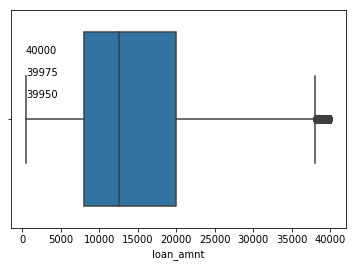

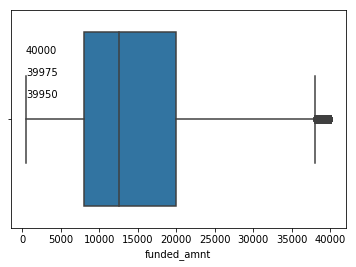

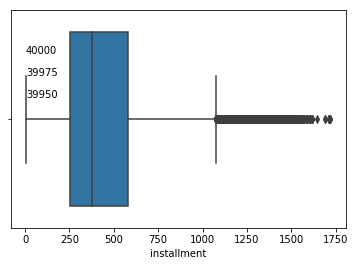

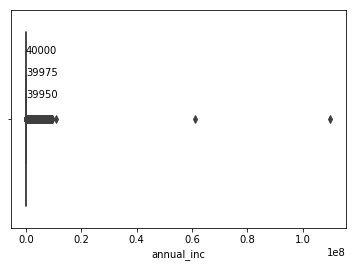

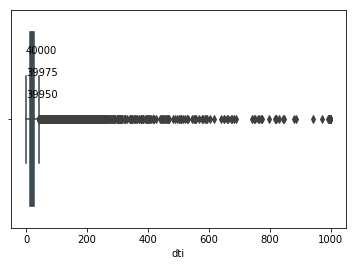

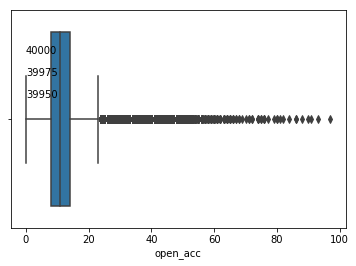

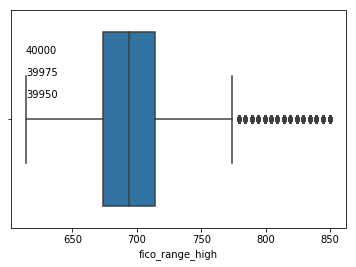

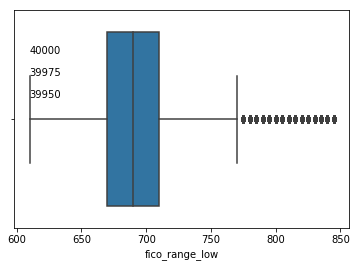

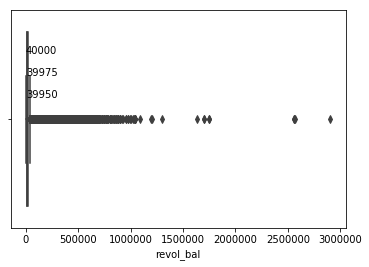

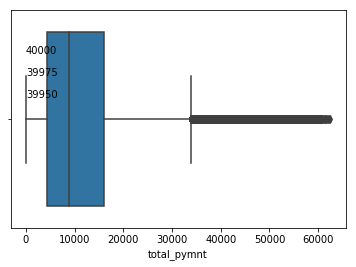

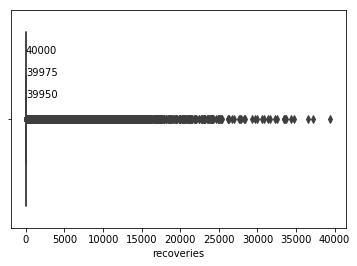

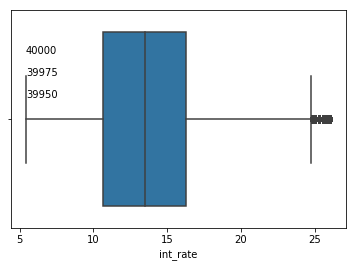

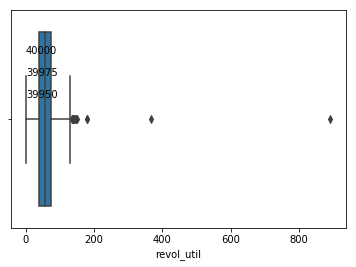

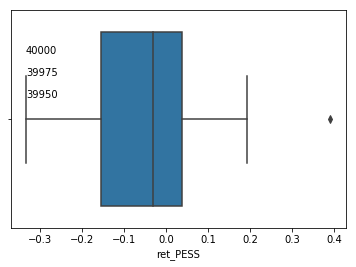

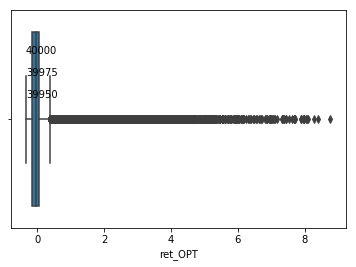

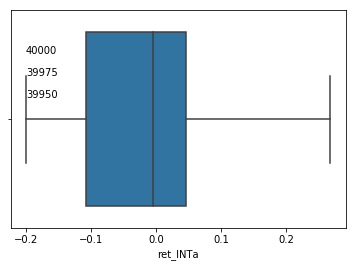

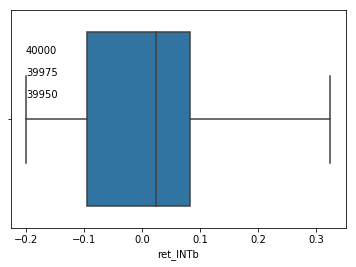

term
Counter({' 36 months': 1265028, ' 60 months': 500318})


grade
Counter({'C': 523178, 'B': 522179, 'A': 297833, 'D': 255361, 'E': 116674, 'F': 38625, 'G': 11496})


emp_length
Counter({'10+ years': 587600, '2 years': 158921, '< 1 year': 146357, '3 years': 140119, '1 year': 115227, '5 years': 108836, '4 years': 105341, None: 104917, '6 years': 80647, '8 years': 75882, '7 years': 74729, '9 years': 66770})


home_ownership
Counter({'MORTGAGE': 872193, 'RENT': 699488, 'OWN': 192921, 'ANY': 508, 'OTHER': 182, 'NONE': 54})


verification_status
Counter({'Source Verified': 670936, 'Not Verified': 563767, 'Verified': 530643})


loan_status
Counter({'Current': 792269, 'Fully Paid': 743049, 'Charged Off': 191934, 'Late (31-120 days)': 20442, 'In Grace Period': 8753, 'Late (16-30 days)': 5758, 'Does not meet the credit policy. Status:Fully Paid': 1988, 'Does not meet the credit policy. Status:Charged Off': 761, 'Default': 392})


purpose
Counter({'debt_consolidation': 1018185, 'credit_card': 

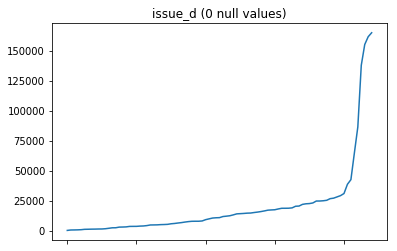

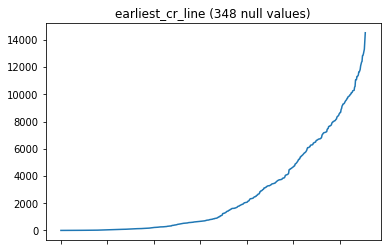

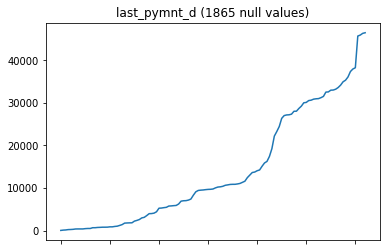

In [24]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [25]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)
final_data = final_data[final_data['loan_amnt']<=38000]
final_data = final_data[final_data['funded_amnt']<=38000]
final_data = final_data[final_data['installment']<=1000]
final_data = final_data[final_data['annual_inc']<=60000000.0]
final_data = final_data[final_data['open_acc']<=22]
final_data = final_data[final_data['fico_range_high']<=775]
final_data = final_data[final_data['fico_range_low']<=775]
final_data = final_data[final_data['revol_bal']<=2500000]
final_data = final_data[final_data['total_pymnt']<=35000]
final_data = final_data[final_data['int_rate']<=25]
final_data = final_data[final_data['revol_util']<=380]
final_data = final_data[final_data['ret_PESS']<=0.35]
final_data = final_data[final_data['ret_OPT']<=32000]
final_data = final_data[final_data['ret_PESS']<=0.35]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 245203 rows


In [26]:
# Remove all loans that are still current
n_rows = len(final_data)

currentloans = []
currentloans = final_data['loan_status'].map(lambda test: test == 'Current')
if currentloans.sum() > 0:
    print("Found " + str(currentloans.sum()) + " current loans which were removed")
    final_data= final_data[~currentloans]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Found 681128 current loans which were removed
Removed 681128 rows


In [27]:
# Only include loans isssued since 2010
n_rows = len(final_data)
#print(final_data['issue_d'])

final_data = final_data[final_data['issue_d']>=datetime.datetime.strptime('2010-01-01', "%Y-%m-%d").date()]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 40697 rows


### Drop null values

In [28]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data.dropna(axis=0,subset= required_cols,inplace=True) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 76 rows


### Visualize clean data

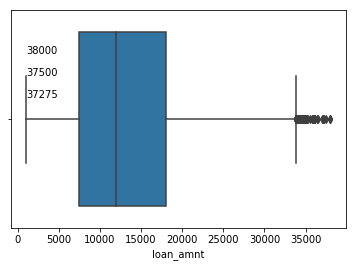

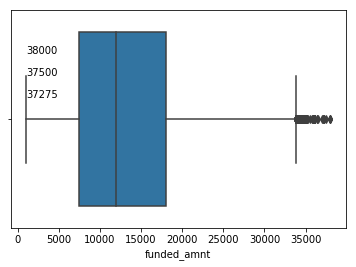

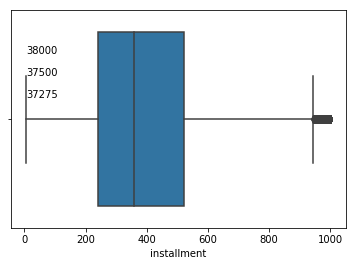

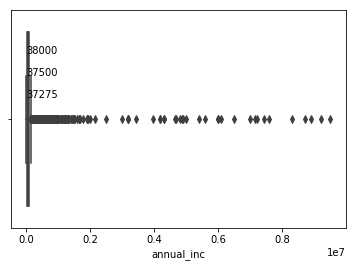

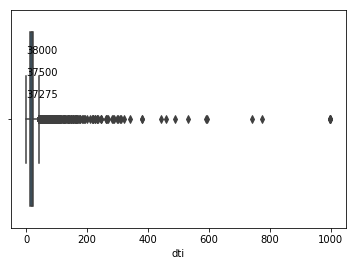

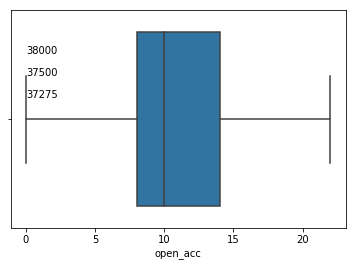

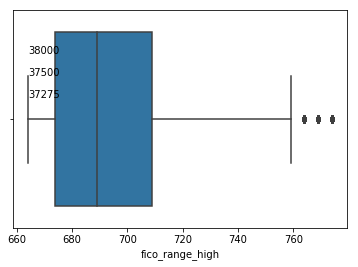

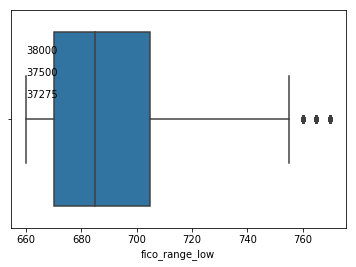

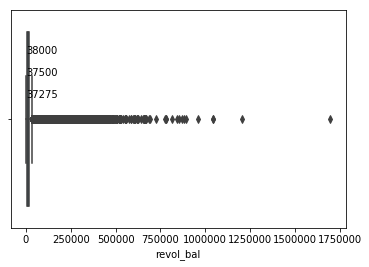

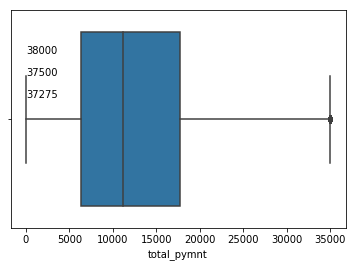

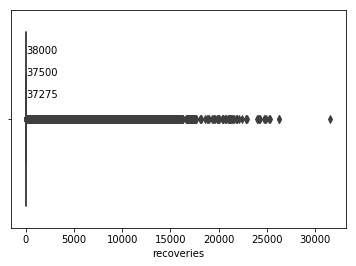

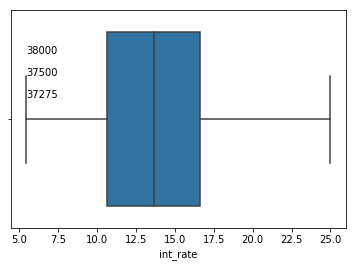

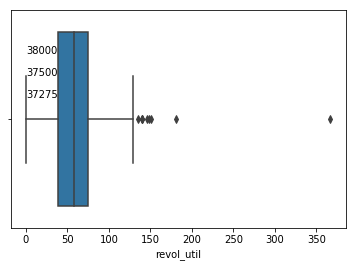

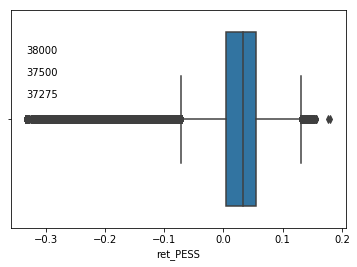

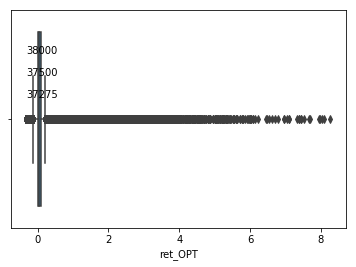

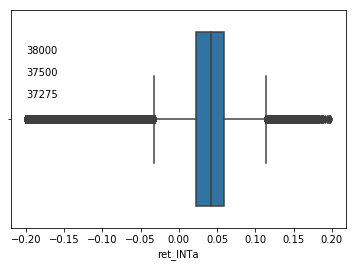

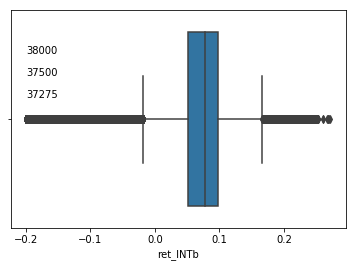

term
Counter({' 36 months': 611664, ' 60 months': 186578})


grade
Counter({'B': 238599, 'C': 228716, 'D': 123675, 'A': 122712, 'E': 59054, 'F': 20284, 'G': 5202})


emp_length
Counter({'10+ years': 253968, '2 years': 73051, '3 years': 64522, '< 1 year': 63680, '1 year': 53030, '5 years': 51268, '4 years': 48332, None: 44813, '6 years': 39169, '7 years': 37836, '8 years': 37656, '9 years': 30917})


home_ownership
Counter({'MORTGAGE': 381278, 'RENT': 334971, 'OWN': 81791, 'ANY': 121, 'OTHER': 46, 'NONE': 35})


verification_status
Counter({'Source Verified': 299683, 'Not Verified': 254306, 'Verified': 244253})


loan_status
Counter({'Fully Paid': 605285, 'Charged Off': 163640, 'Late (31-120 days)': 16524, 'In Grace Period': 7003, 'Late (16-30 days)': 4509, 'Does not meet the credit policy. Status:Fully Paid': 697, 'Default': 321, 'Does not meet the credit policy. Status:Charged Off': 263})


purpose
Counter({'debt_consolidation': 471666, 'credit_card': 174257, 'home_improvement': 47117

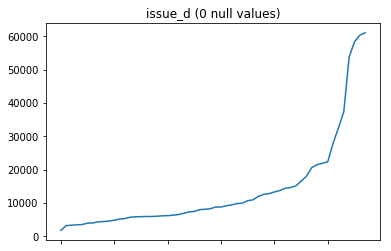

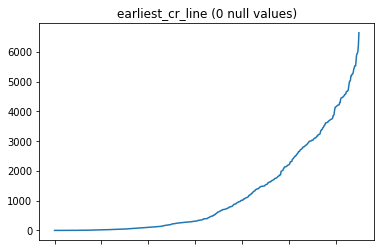

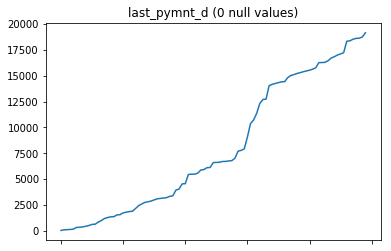

In [29]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

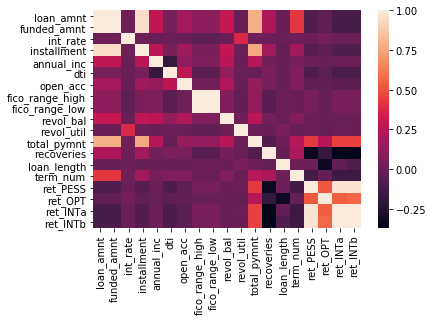

In [30]:
# Visualize the feature correlations
# sns scatter or pairplot

correlation_matrix = final_data.corr()
seaborn.heatmap(correlation_matrix.T,xticklabels=correlation_matrix.columns,yticklabels=correlation_matrix.columns)

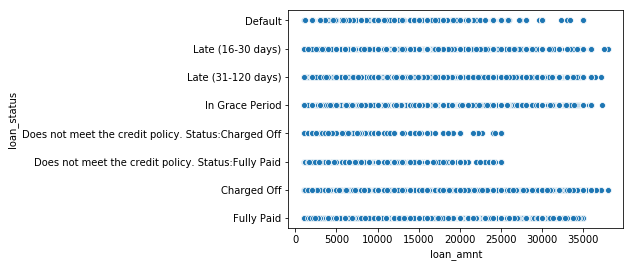

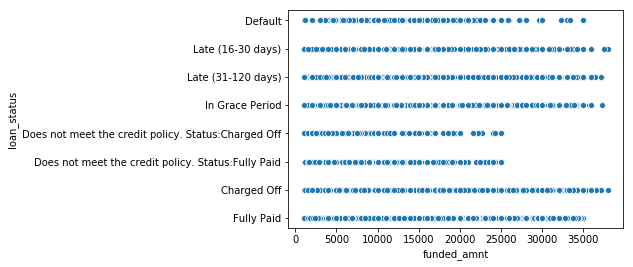

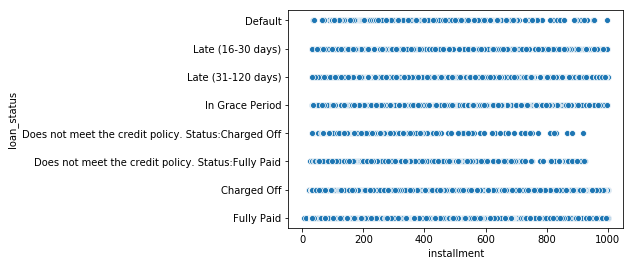

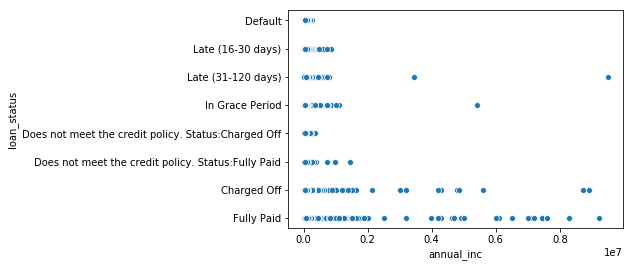

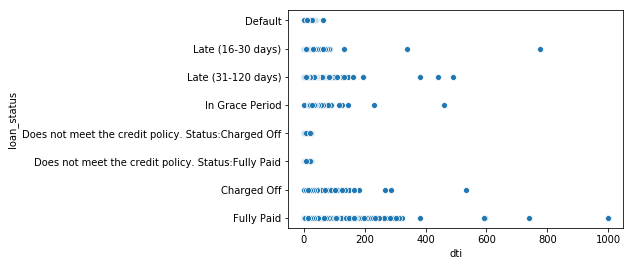

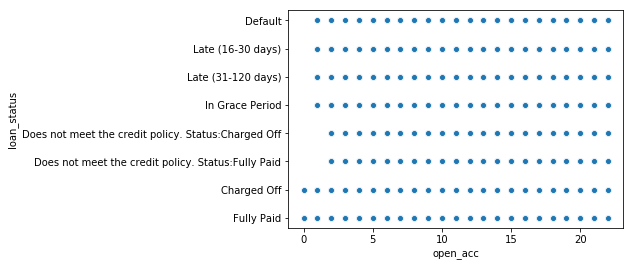

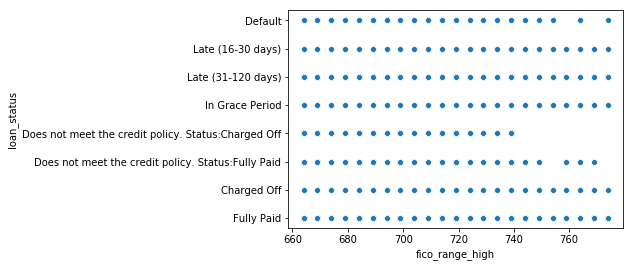

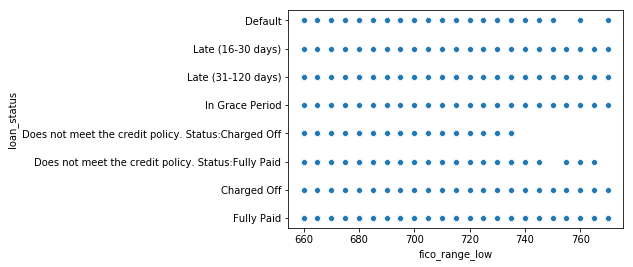

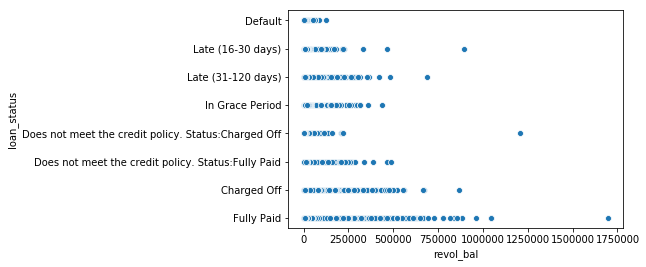

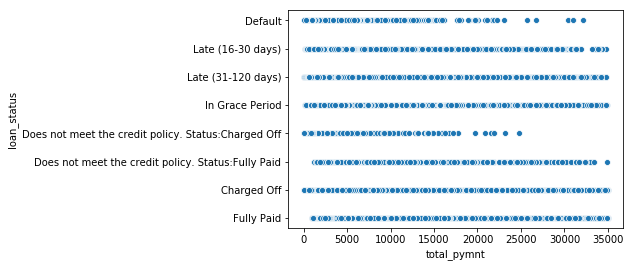

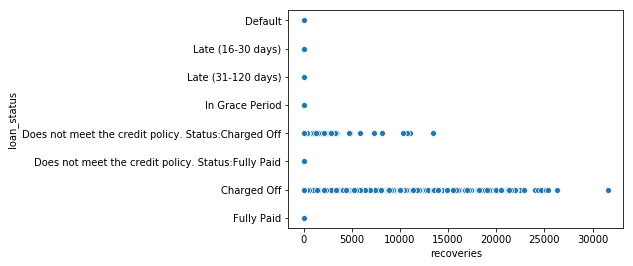

In [35]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
#seaborn.pairplot(final_data,x_vars=cols_to_pick,y_vars=final_data['loan_status'])

for i,feature in enumerate(float_cols):
    plt.figure(i)
    seaborn.scatterplot(final_data[feature],final_data['loan_status'])

# 

    
    

What do you observe after removing the outliers?

### Data Exploration
Solution to Q.7 from the handout

In [31]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby('grade')['ret_PESS'].mean()  # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_OPT'].mean() # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade')['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean() # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean()

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
#combined['return_INTc'] = ret_by_grade_INTc

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,15.372782,7.867201,13.424331,0.014974,0.051039,0.029154,0.063193
B,29.890560,15.943068,13.727074,0.011850,0.061672,0.026973,0.060592
C,28.652464,26.532468,13.798120,-0.000521,0.057975,0.017599,0.049740
D,15.493422,35.391146,13.886580,-0.007318,0.059580,0.011063,0.042185
E,7.398007,45.995191,13.949383,-0.020534,0.045843,-0.002027,0.027002
F,2.541084,52.578387,14.062609,-0.027173,0.044736,-0.009840,0.017982
G,0.651682,57.324106,14.014544,-0.044181,0.015517,-0.024819,0.000768


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [32]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features.remove('total_pymnt')
continuous_features.remove('recoveries')

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

In [33]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )